In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Import Data + Datalloading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/asl_dataset'

images = []
labels = []

dataset = os.listdir(path)

for folder in dataset:
    subpath = os.path.join(path, folder)
    imgs = os.listdir(subpath)
    label = ord(folder)

    if label < 58:
      label -= 48
    else:
      label -= 87
    # Iterate through images in each letter
    for img in imgs:
        img_path = os.path.join(subpath, img)
        images.append(Image.open(img_path))
        labels.append(label)
    print(folder)


2


KeyboardInterrupt: 

In [ ]:
#pil_images_train = [Image.fromarray(image) for image in images]
x_train = []
y_train = []
x_test = []
y_test= []
for i in range(len(images)):
  if(i % 70 < 56):
    x_train.append(images[i])
    y_train.append(labels[i])
  else:
    x_test.append(images[i])
    y_test.append(labels[i])

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),  # Normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

transformed_train = torch.stack([transform(image.convert("RGB")) for image in x_train])
train_dataset = torch.utils.data.TensorDataset(transformed_train, y_train)

transformed_test = torch.stack([transform(image.convert("RGB")) for image in x_test])
test_dataset = torch.utils.data.TensorDataset(transformed_test, y_test)

tensor(32.)
torch.Size([3, 224, 224])


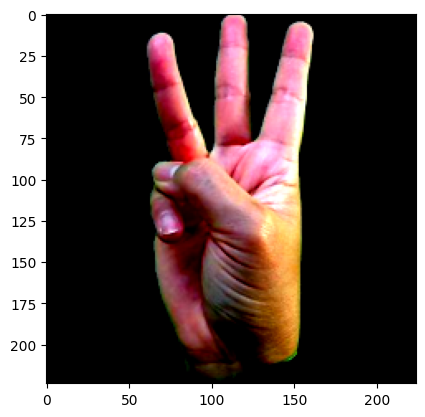

In [ ]:
# Code to display images
images= train_dataset[1812][0]
print(train_dataset[1812][1])
print(images.shape)
image = images.permute(1,2,0)
image = image/2 + 0.5
plt.imshow(image)


In [ ]:
print(min(labels))
print(max(labels))


tensor(0.)
tensor(35.)


Model Training

In [ ]:
def train(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0):

    train_loss = []
    train_counter = []
    model.train() #set to training mode

    for batch_idx, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.type(torch.LongTensor)
        targets = targets.view(-1).to(device)

        optimizer.zero_grad()
        output = model(images)

        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')

    assert len(train_loss) == len(train_loader)
    return train_loss

def test(model: nn.Module,
         loss_fn: nn.modules.loss._Loss,
         test_loader: torch.utils.data.DataLoader,
         epoch: int=0):
    # ----------- <Your code> ---------------
    test_counter = []
    model.eval() # we need to set the mode for our model

    test_loss = 0
    correct = 0
    test_stat = {}
    predlist = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.type(torch.LongTensor)
            targets = targets.view(-1).to(device)

            output = model(images)
            test_loss += loss_fn(output, targets).item() * 100
            pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
            correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
            predlist += (pred)
    test_loss /= len(test_loader.dataset)
    test_counter.append(len(train_loader.dataset)*epoch)

    test_stat['loss'] = test_loss
    test_stat['accuracy'] = 100.*correct/len(test_loader.dataset)
    test_stat['prediction'] = torch.Tensor(predlist)
    #print(f"Pred: {len(test_stat['prediction'])} Data: {len(test_loader.dataset)}")

    print(f"Test result on epoch {epoch}: total sample: {test_counter}, Avg loss: {test_stat['loss']:.3f}, Acc: {test_stat['accuracy']}%")

    # ----------- <End Your code> ---------------
    # dictionary output should include loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" should be a 1D tensor
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)
    return test_stat


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

In [ ]:
resnet50 = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')

for param in resnet50.parameters():
      param.requires_grad = False

resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, 36)
resnet50 = resnet50.to(device)
criterion = nn.CrossEntropyLoss()
max_epoch = 20

test_stat = {}
accuracies = []
losses = []
prev_loss = 0
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001, betas=(0.5, 0.999))
for epoch in range(1, max_epoch+1):
  train(resnet50, criterion, optimizer, train_loader, epoch)
  teststat = test(resnet50, criterion, test_loader, epoch)
  accuracies.append(teststat['accuracy'].cpu())
  losses.append(teststat['loss'])

  if(abs(prev_loss - teststat['loss']) < 0.01):
    break
  prev_loss = teststat['loss']


Epoch 1: [0/2016] Loss: 3.5129361152648926
Epoch 1: [1000/2016] Loss: 2.2706820964813232
Epoch 1: [2000/2016] Loss: 1.9031918048858643
Test result on epoch 1: total sample: [2016], Avg loss: 1.922, Acc: 68.73747253417969%
Epoch 2: [0/2016] Loss: 1.8818126916885376
Epoch 2: [1000/2016] Loss: 1.6183459758758545
Epoch 2: [2000/2016] Loss: 0.8707383275032043
Test result on epoch 2: total sample: [4032], Avg loss: 1.395, Acc: 74.14830017089844%
Epoch 3: [0/2016] Loss: 0.7661367058753967
Epoch 3: [1000/2016] Loss: 0.7898680567741394
Epoch 3: [2000/2016] Loss: 0.5554251670837402
Test result on epoch 3: total sample: [6048], Avg loss: 1.156, Acc: 76.55310821533203%
Epoch 4: [0/2016] Loss: 0.6438839435577393
Epoch 4: [1000/2016] Loss: 0.41051769256591797
Epoch 4: [2000/2016] Loss: 0.37747031450271606
Test result on epoch 4: total sample: [8064], Avg loss: 0.966, Acc: 77.55511474609375%
Epoch 5: [0/2016] Loss: 0.470517098903656
Epoch 5: [1000/2016] Loss: 0.35604631900787354
Epoch 5: [2000/2016] 

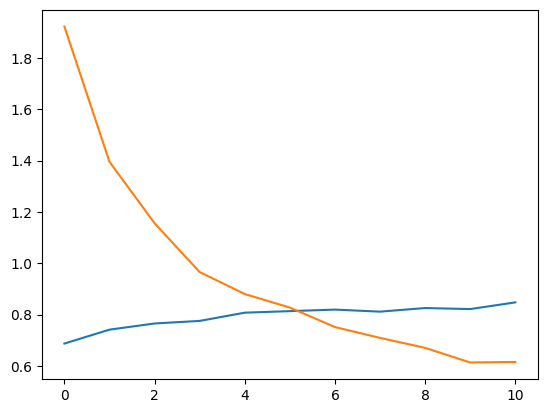

In [ ]:
accuracies = [i/100 for i in accuracies]
plt.plot(accuracies)
plt.plot(losses)

tensor([[1.0660e-05, 1.6051e-05, 3.7697e-07, 1.4308e-05, 2.0077e-06, 1.8813e-06,
         4.2079e-07, 1.8273e-06, 4.2505e-06, 7.7277e-05, 5.9644e-05, 2.6136e-05,
         4.1883e-07, 3.2380e-05, 7.1025e-04, 7.5075e-04, 3.7333e-07, 3.4442e-07,
         9.9730e-01, 1.5431e-05, 7.4097e-06, 5.4200e-05, 1.7543e-04, 1.3253e-05,
         2.7087e-06, 2.4377e-07, 4.9664e-06, 1.2240e-05, 3.5878e-04, 1.4422e-04,
         4.6913e-05, 7.1852e-06, 5.7271e-07, 3.4114e-05, 9.4149e-05, 2.0411e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


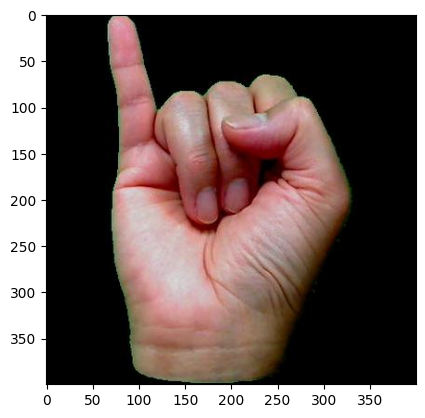

In [ ]:
banana = Image.open(r'/content/drive/MyDrive/hand2_i_dif_seg_2_cropped.jpeg')

plt.imshow(banana)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),  # Normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#extra trnadmform : ,  # Convert to tensor transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
pixels = transform(banana.convert("RGB"))
resnet50.to(device)
pixels = pixels.to(device)
output = resnet50(pixels.unsqueeze(0))

# Apply softmax to convert logits to probabilities
probs = F.softmax(output, dim=1)
print(probs)


In [ ]:
predicted_class = torch.argmax(probs, dim = 1).item()
# Get the index of the class with the highest probability
#predicted_class = torch.argmax(probs, dim=1)

if predicted_class < 10:
      letter = predicted_class + 48
else:
      letter = predicted_class + 87

print(chr(letter))  # Convert tensor to Python scalar

i


Saving Model

In [ ]:
print("Our model: \n\n", resnet50, '\n')
print("The state dict keys: \n\n", resnet50.state_dict().keys())

from google.colab import files

torch.save(resnet50.state_dict(), 'aisl.pth')

# download checkpoint file
files.download('aisl.pth')

Our model: 

 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>